# Preprocessing IMU Data

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
import profile_utils

In [10]:
"""Preprocessing IMU data before it goes into maneuver detection algorithms"""
from typing import Dict, Union
import numpy as np
import simdkalman  # lightweight package, not currently a part of the docker
from scipy.ndimage import uniform_filter1d
import yaml


# In KF, it is the ratio between the process noise and the observation noise
# that matters
KF_CONFIG = {
    "moving_window_size": None,
    "kalman_process_noise": 1.,
    "kalman_observation_noise": 1.,
    "kalman_initial_covariance": 10,
}
# sampling rate ~30Hz, and we want to see features of ~0.1 s long
MOVING_AVERAGE_CONFIG = {
    "moving_window_size": 4,
    "kalman_process_noise": None,
    "kalman_observation_noise": None,
    "kalman_initial_covariance": None,
}


class IMUPreprocessor():
    """Preprocess IMU data before it goes into maneuver detection algorithms.

    Roughly follows methods from M. Tabatabaei et al. "Driver Maneuver
    Identification Using Inertial Sensors and a Machine Learning Algorithm"
    """
    def __init__(
        self,
        moving_window_size: int = None,
        kalman_process_noise: float = None,
        kalman_observation_noise: float = None,
        kalman_initial_covariance: float = None,
    ):
        # moving average filter
        self.moving_window_size = moving_window_size
        # kalman filter - see https://simdkalman.readthedocs.io/en/latest/
        self.kalman_process_noise = kalman_process_noise
        self.kalman_observation_noise = kalman_observation_noise
        self.kalman_initial_covariance = kalman_initial_covariance

        self._init_tools()

    def _init_tools(self):
        """Initialize tools for preprocessing based on configuration"""

        # Kalman parameters should both be either set or unset
        if (
            (self.kalman_observation_noise is None)
            ^ (self.kalman_process_noise is None)
        ):
            raise ValueError("Kalman filter parameters incorrectly set")

        self.kalman_filter = (
            simdkalman.KalmanFilter(
                state_transition=[[1]],  # A
                process_noise=self.kalman_process_noise,  # Q
                observation_model=np.array([[1]]),  # H
                observation_noise=self.kalman_observation_noise  # R
            )
            if self.kalman_process_noise is not None else None
        )

    def update_cfg(self, config: Union[str, dict]):
        """Update configuration from a file or dictionary"""
        if isinstance(config, str):
            with open(config, 'r') as f:
                cfg = yaml.safe_load(f)
        else:
            cfg = config

        for attr_name in [
            "moving_window_size",
            "kalman_process_noise",
            "kalman_observation_noise",
            "kalman_initial_covariance",
        ]:
            setattr(
                self,
                attr_name,
                cfg[attr_name] if attr_name in cfg else None
            )
        self._init_tools()

    def _is_imu_values_name(self, key: str) -> bool:
        """name of a column corresponds to either acceleration or gyro"""
        return "time" not in key

    def _moving_average(self, data: np.ndarray) -> np.ndarray:
        """Moving average filter for every key in data except timestamps

        If the moving window size is not set, returns data unchanged.

        Parameters
        ----------
            data : array of the dimension (n_sensors, n_time_points)
            Returns
        -------
            array smooth values of the dimension (n_sensors, n_time_points)
        """
        # This solution relies on scipy.ndimage. If that library becomes
        # unavailable on k3y, look at
        # https://stackoverflow.com/questions/13728392/moving-average-or-running-mean,
        # mind edge efects
        return (
            uniform_filter1d(data, size=self.moving_window_size, axis=1)
            if self.moving_window_size is not None else data
        )

    def _kalman_smoother(self, data):
        """Kalman filter with noise-only term

        relies on https://simdkalman.readthedocs.io/en/latest/
        """
        if self.kalman_filter is None:
            return data

        smoothed = self.kalman_filter.smooth(
            data,
            initial_value=[0],
            initial_covariance=[[self.kalman_initial_covariance]]
        ).states.mean

        return np.squeeze(smoothed)

    def _normalize(self, data: np.ndarray) -> np.ndarray:
        # TODO: normalize to -1..1 min-max based on the training data
        print("WARNING: normalization is not implemented yet")
        return data

    def preprocess(self, data: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """Run all preprocessing steps on the data

        Parameters:
        -----------
            data : dictionary of arrays, obtained by merging the acceleration
                and gyro dataframes. Keys are the names of the columns
        Returns:
        --------
            dictionary of arrays, with the keys same as the input except an
            extra suffix
        """
        # transform the input dictionary into an array for numerical efficiency
        key_lookup = {}
        data_stack = []
        non_imu_keys = []

        i = 0
        for key, vals in data.items():
            if self._is_imu_values_name(key):
                key_lookup[i] = key
                data_stack.append(vals)
                i += 1
            else:
                non_imu_keys.append(key)
        data_np = np.vstack(data_stack)

        # apply preprocessing steps one by one
        data_np = self._moving_average(data_np)
        data_np = self._kalman_smoother(data_np)
        data_np = self._normalize(data_np)

        # split the result back into a dictionary
        result = {key: data[key] for key in non_imu_keys}
        for i, key in key_lookup.items():
            result[key] = data_np[i, :]

        return result

Fetch some example data

In [33]:
@profile_utils.inference_profile(repetitions=100)
def fetch_data():
    df_a = pd.read_parquet("data/accel_2023-07-10_22-00-00.parquet")
    df_g = pd.read_parquet("data/gyro_2023-07-10_22-00-00.parquet")
    return df_a, df_g

df_a, df_g = fetch_data()

# all data in the dictionary
times_a = df_a["timestamp(epoch in sec)"].values
times_g = df_g["timestamp(epoch in sec)"].values

data_full = {'time': times_a - times_a[0]}

for col in df_a.columns:
    if col != "timestamp(epoch in sec)":
        data_full[col] = df_a[col].values
for col in df_g.columns:
    if col != "timestamp(epoch in sec)":
        data_full[col] = df_g[col].values

Average inference speed (over 100 runs): 0.015750 seconds


Split Data into 8 second windows

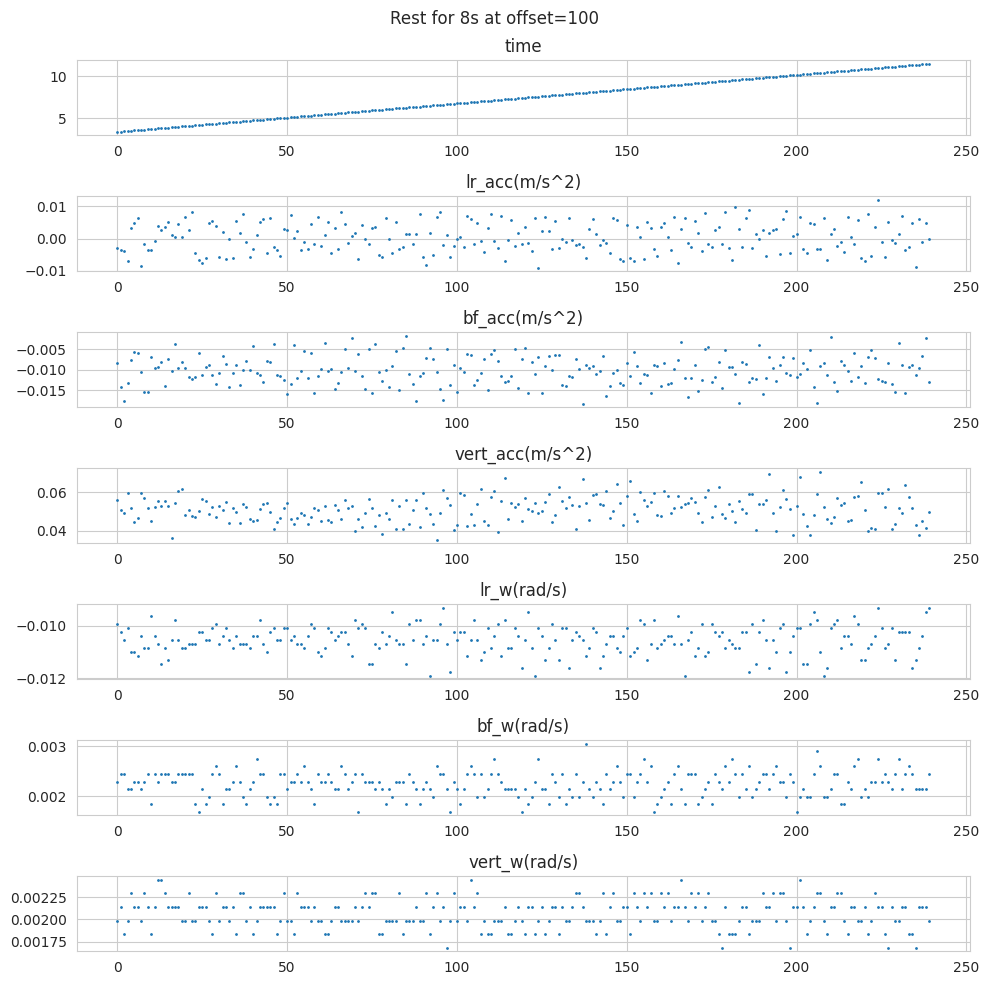

In [34]:
# rest data (data_0)
piece = 240
offset = 100

data_0 = {
    col: data_full[col][offset : offset + piece] for col in data_full
}

f = plt.figure(figsize=(10, 10))
for i, col in enumerate(data_0):
    plt.subplot(7, 1, i+1)
    plt.scatter(range(piece), data_0[col], s=1)
    plt.title(col)
plt.suptitle(f"Rest for 8s at offset={offset}")
plt.tight_layout()

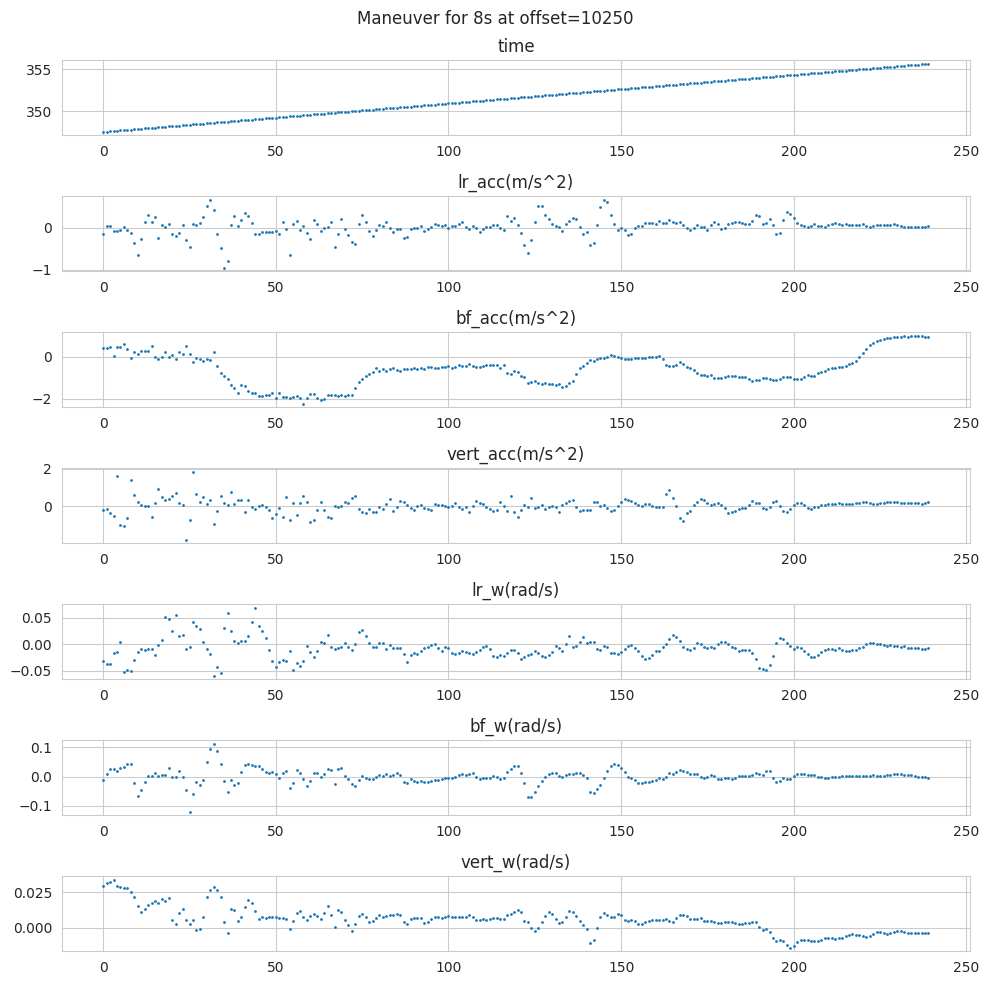

In [35]:
# moving data (data_1)
piece = 240
offset = 10250

data_1 = {
    col: data_full[col][offset : offset + piece] for col in data_full
}

f = plt.figure(figsize=(10, 10))
for i, col in enumerate(data_1):
    plt.subplot(7, 1, i+1)
    plt.scatter(range(piece), data_1[col], s=1)
    plt.title(col)
plt.suptitle(f"Maneuver for 8s at offset={offset}")
plt.tight_layout()

Apply the Kalman filter

In [47]:
config = {
    "moving_window_size": 3,
    "kalman_process_noise": None,
    "kalman_observation_noise": None,
}

preprocessor = IMUPreprocessor()
preprocessor.update_cfg(config)

@profile_utils.inference_profile(repetitions=10)
def preprocess_data():
    return preprocessor.preprocess(data_0)

In [50]:
def plot_window_averages():
    """compute and plot window averages for both rest and maneuver"""

    preprocessor = IMUPreprocessor(**config)

    piece = len(data_0["time"])
    plot_setups = {"at_rest": data_0, "at-maneuver": data_1}

    for name, data in plot_setups.items():
        dw = preprocessor.preprocess(data)
        plt.figure(figsize=(7, 10))
        for i, col in enumerate(data):
            ax = plt.subplot(7, 1, i+1)
            ax.scatter(range(piece), data[col], s=6, label="raw")
            if "time" not in col:
                ax.plot(
                    range(piece), dw[col],
                    color="red", lw=1, label=f"windowed ws={4}")
            plt.title(col)
            ax.legend()
        plt.suptitle(
            f"Moving average for the {name} data, "
            + f"window size = {config['moving_window_size']}",
            fontsize=16,
        )
        plt.tight_layout()
        plt.show()

Average inference speed (over 10 runs): 0.000196 seconds


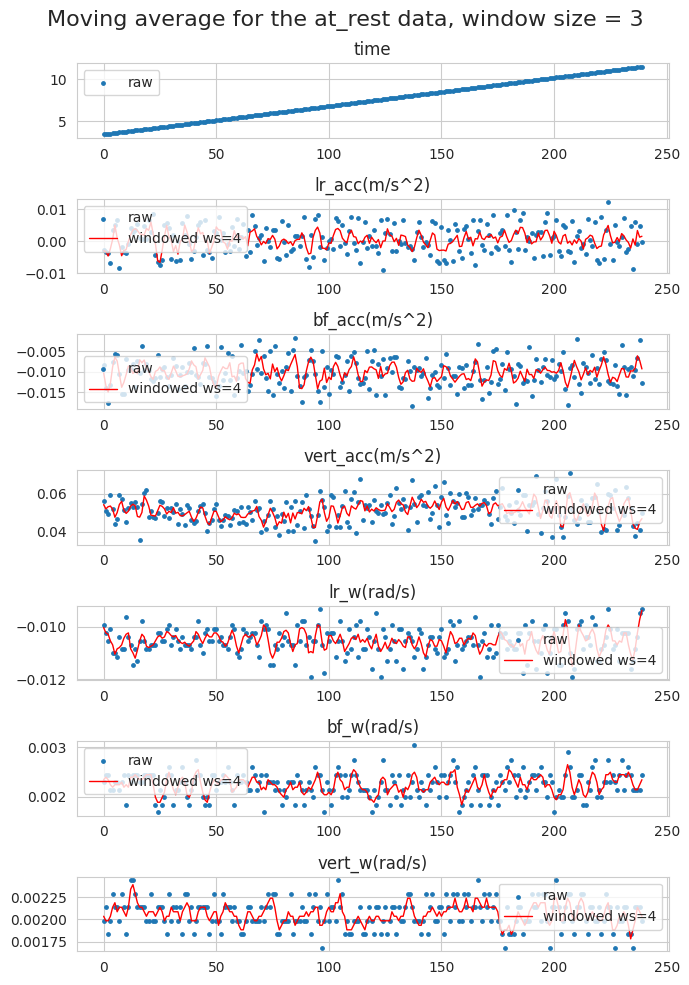

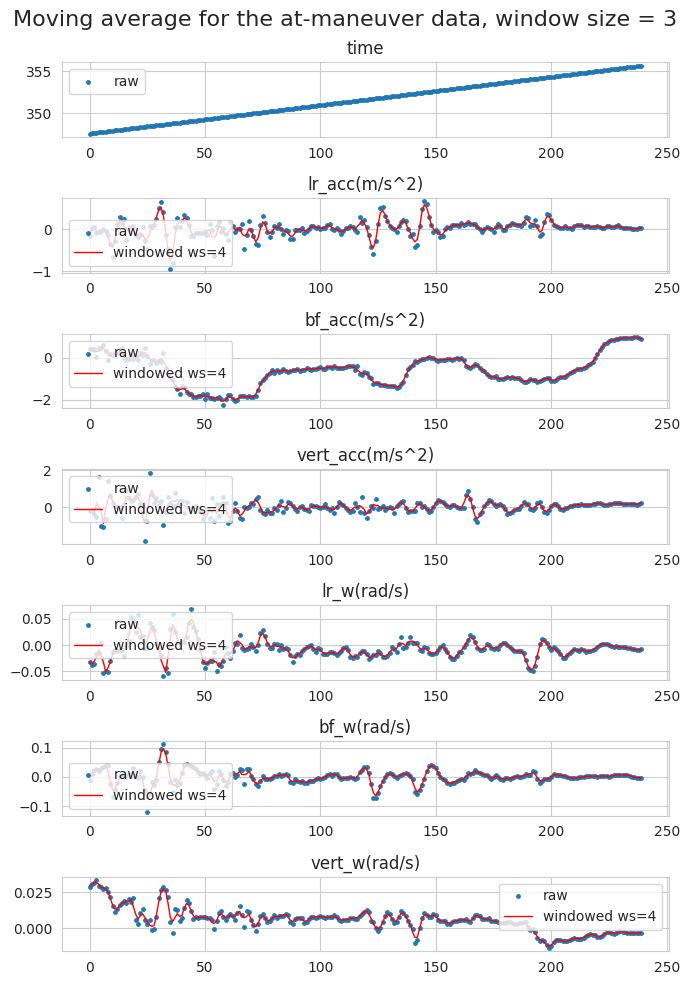

In [51]:
preprocess_data()
plot_window_averages()

Test the DTW

In [78]:
data_0.keys()

dict_keys(['time', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)'])

In [80]:
np.column_stack((data_0['time'], data_0['lr_acc(m/s^2)']))

array([[ 3.39072037e+00, -2.76709833e-03],
       [ 3.42462754e+00, -3.45772503e-03],
       [ 3.45853472e+00, -3.71304943e-03],
       [ 3.49244165e+00, -6.83862934e-03],
       [ 3.52634883e+00,  3.41880719e-03],
       [ 3.56025600e+00,  4.97329664e-03],
       [ 3.59416342e+00,  6.47367887e-03],
       [ 3.62807059e+00, -8.51393983e-03],
       [ 3.66197777e+00, -1.79863136e-03],
       [ 3.69588518e+00, -3.46483334e-03],
       [ 3.72979236e+00, -3.62870980e-03],
       [ 3.76369953e+00, -8.15312143e-04],
       [ 3.79760671e+00,  4.06633490e-03],
       [ 3.83151364e+00,  2.72886138e-03],
       [ 3.86542082e+00,  3.49220496e-03],
       [ 3.89932799e+00,  5.31721131e-03],
       [ 3.93323541e+00,  1.09286295e-03],
       [ 3.96714258e+00,  4.95685454e-04],
       [ 4.00104976e+00,  4.55840399e-03],
       [ 4.03495717e+00,  5.98849238e-04],
       [ 4.06886435e+00,  6.61437968e-03],
       [ 4.10277152e+00,  2.81365460e-03],
       [ 4.13667846e+00,  8.30766650e-03],
       [ 4.

In [84]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

@profile_utils.inference_profile(repetitions=10)
def test_dtw():
    x = np.column_stack((data_0['time'], data_0['lr_acc(m/s^2)']))
    y = np.column_stack((data_1['time'], data_1['lr_acc(m/s^2)']))
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance

test_dtw()

Average inference speed (over 10 runs): 0.031091 seconds


82597.95414251313

In [ ]:
"""Spectrograms and scaleograms for IMU data.

Consider switching to https://github.com/PyWavelets/pywt/tree/masterhttps://github.com/PyWavelets/pywt/tree/master
"""
from scipy.signal import spectrogram
import numpy as np
from typing import Tuple
from profile_utils import memory_profile, inference_profile
import pickle

def spectrogram_complex(
        data: np.ndarray,
        sample_rate: float = 30.,
        segment_length_s: float = 2.,
        overlap_ratio: float = 0.9,
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Compute spectrogram of IMU data.

    Parameters:
    -----------
        data:  dimension (n_imu_sensors, n_time_points)
        sample_rate: sample rate (Hz) of our IMU data
        segment_length_s: length of each segment (s)
        overlap_ratio: overlap between segments / length of a segment
    Returns:
    --------
        f:  frequency bins
        t:  time bins
        Sxx_re: (n_imu_sensors, n_time_points, n_freq_points):
            real part of the complex spectrogram
        Sxx_im: (n_imu_sensors, n_time_points, n_freq_points):
            imaginary part of the complex spectrogram
    """
    nperseg = sample_rate * segment_length_s
    f, t, Sxx = spectrogram(
        data,
        mode='complex',
        fs=sample_rate,
        nperseg=int(nperseg),
        noverlap=int(overlap_ratio * nperseg),
        window='hann',
    )
    return f, t, Sxx.real, Sxx.imag


def test_spectrogram_complex():
    """Tests for spectrogram_complex.

    Only works in the dev repo, swap the data if wou want to make this
    into production
    """
    import pickle
    import matplotlib.pyplot as plt
    # Data: swap this block for production
    all_inputs = pickle.load(
        open("data/preprocessed_and_raw_8s_data.pkl", "rb")
    )
    data = all_inputs['smooth_ride_data']
    # Make the spectrogram
    freq, t, Sxx_re, Sxx_im = spectrogram_complex(data)
    # Plot, save
    scale = max(np.max(np.abs(Sxx_re)), np.max(np.abs(Sxx_im)))
    f = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(t, freq, Sxx_re[1], cmap='bwr', vmin=-scale, vmax=scale)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Smooth - real part')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.pcolormesh(t, freq, Sxx_im[1], cmap='bwr', vmin=-scale, vmax=scale)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Smooth - imag part')
    plt.colorbar()
    f.savefig('spectrogram_complex.png', dpi=300)

# @memory_profile(1) 
@inference_profile(1)
def benchmark_spectrogram_complex(data: np.array):
    """Benchmarks basic flow on k3y"""
    freq, t, Sxx_re, Sxx_im = spectrogram_complex(data)
    scale = max(np.max(np.abs(Sxx_re)), np.max(np.abs(Sxx_im)))

@memory_profile(1) 
# @inference_profile(10)
def benchmark_scaleograms(data: np.array):
    """Benchmarks basic flow on k3y"""
    scale_list = np.arange(start=10, stop=200, step=5)
    sample_rate = 30
    times = np.arange(data[1].size) / float(sample_rate)

    wavelets = ['gaus1', 'mexh', 'morl']
    for i, wavelet in enumerate(wavelets):
        coeffs, frequencies = pywt.cwt(data, scale_list, wavelet)



if __name__ == "__main__":
    # Data: swap this block for production
    all_inputs = pickle.load(
        open("data/preprocessed_and_raw_8s_data.pkl", "rb")
    )
    data = all_inputs['smooth_ride_data']

    # print("benchmarking spectrogram_complex")
    # benchmark_spectrogram_complex(data)
    # print()

    print("benchmarking scaleograms")
    import pywt
    benchmark_scaleograms(data)


In [96]:
# create toy data
def create_sample_data(time_length):
    times = np.linspace(0, 8, time_length * 30)  # 8 seconds sampled at 30 Hz
    randoms = 20 * np.random.randn(6, 3)
    data = {'time (s)': times}
    data.update(
        {
            key: randoms[i, 0] * np.sin(times + randoms[i, 1] + randoms[i, 2])
            for i, key in enumerate(
                ['lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)',
                    'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)']
            )
        }
    )
    return data

print(create_sample_data(8).keys())

dict_keys(['time (s)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)'])


In [110]:
import numpy as np
from profile_utils import memory_profile, inference_profile
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

@inference_profile(repetitions=100)
def benchmark_dtw(data_0, data_1):
    x = np.column_stack((data_0['time (s)'], data_0['lr_acc(m/s^2)']))
    y = np.column_stack((data_1['time (s)'], data_1['lr_acc(m/s^2)']))
    distance, path = fastdtw(x, y, dist=euclidean)

In [114]:
data_0 = create_sample_data(8)
data_1 = create_sample_data(12)

test_dtw(data_0, data_1)

Average inference speed (over 100 runs): 0.039976 seconds


2460.876563088593